In [57]:
import os
import pandas as pd

audio_folder = './cats_dogs'

data = []

for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        contains_cats = 1 if 'cat' in filename.lower() else 0
        data.append([filename.split('.')[0], contains_cats])

df = pd.DataFrame(data, columns=['Название', 'Класс'])

df.to_csv('audio_dataframe.csv', index=False)

In [58]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import librosa.util

class AudioDataset(Dataset):
    def __init__(self, audio_dir, annotations_file, transform=None, sr=16000, fixed_length=16000):
        self.audio_dir = audio_dir
        self.annotations = np.loadtxt(annotations_file, delimiter=",", dtype=str, skiprows=1)
        self.transform = transform
        self.sr = sr  # Частота дискретизации
        self.fixed_length = fixed_length  # Фиксированная длина сигнала
        self.labels = [int(label) for _, label in self.annotations]
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.annotations[idx][0] + ".wav")
        label = int(self.annotations[idx][1])
        
        # Загружаем аудио с помощью librosa
        waveform, sr = librosa.load(audio_path, sr=self.sr)
        
        # Приводим к фиксированной длине
        waveform = librosa.util.fix_length(waveform, size=self.fixed_length)
        
        if self.transform:
            features = self.transform(waveform)
            features = torch.tensor(features, dtype=torch.float32)
        else:
            features = torch.tensor(waveform, dtype=torch.float32)
        
        return features.unsqueeze(0), label  # [1, n_mels, time]

def librosa_mel_spectrogram(waveform, sr=16000, n_fft=1024, hop_length=512, n_mels=64):
    mel_spec = librosa.feature.melspectrogram(
        y=waveform, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [59]:
class AudioClassifier(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8192, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Сплющиваем перед Linear
        x = self.relu(self.fc1(x))  # FC1 -> ReLU
        x = self.fc2(x)  # FC2
        return x


# Гиперпараметры
AUDIO_DIR = "cats_dogs"
ANNOTATIONS_FILE = "audio_dataframe.csv"
INPUT_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 50

transform = lambda x: librosa_mel_spectrogram(x, n_mels=INPUT_DIM)
dataset = AudioDataset(AUDIO_DIR, ANNOTATIONS_FILE, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = AudioClassifier(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Обучаем модель:

In [ ]:
def train_model(model, train_loader, test_loader, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}", end=", ")
        
        # Оценка на тестовой выборке
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_acc = correct_test / total_test
        print(f"Test Acc: {test_acc:.4f}")

train_model(model, train_loader, test_loader, DEVICE, epochs=EPOCHS)

Epoch [1/50], Loss: 6.8220, Train Acc: 0.5520, Test Acc: 0.6429
Epoch [2/50], Loss: 0.6756, Train Acc: 0.6787, Test Acc: 0.8036
Epoch [3/50], Loss: 0.4848, Train Acc: 0.8100, Test Acc: 0.6429
Epoch [4/50], Loss: 0.3667, Train Acc: 0.8507, Test Acc: 0.7500
Epoch [5/50], Loss: 0.3073, Train Acc: 0.9005, Test Acc: 0.8750
Epoch [6/50], Loss: 0.2193, Train Acc: 0.9276, Test Acc: 0.8036
Epoch [7/50], Loss: 0.1480, Train Acc: 0.9548, Test Acc: 0.8750
Epoch [8/50], Loss: 0.1029, Train Acc: 0.9729, Test Acc: 0.8571
Epoch [9/50], Loss: 0.1328, Train Acc: 0.9457, Test Acc: 0.8929
Epoch [10/50], Loss: 0.1181, Train Acc: 0.9683, Test Acc: 0.8393
Epoch [11/50], Loss: 0.0714, Train Acc: 0.9864, Test Acc: 0.8929
Epoch [12/50], Loss: 0.0490, Train Acc: 0.9819, Test Acc: 0.8571
Epoch [13/50], Loss: 0.0393, Train Acc: 0.9910, Test Acc: 0.9107
Epoch [14/50], Loss: 0.0273, Train Acc: 0.9955, Test Acc: 0.8393
Epoch [15/50], Loss: 0.0170, Train Acc: 0.9955, Test Acc: 0.9107
Epoch [16/50], Loss: 0.0095, Train

Извлекаем и визуализируем эмбеддинги:

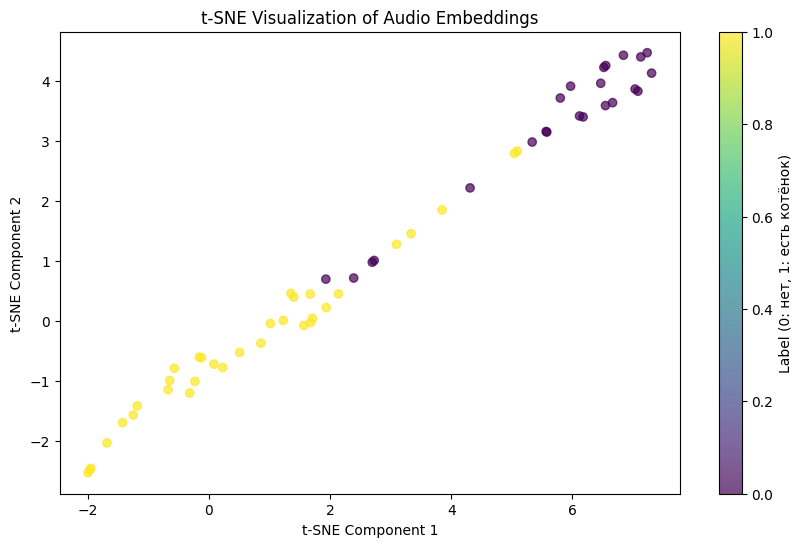

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Извлечение эмбеддингов
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for features, label in dataloader:
            features = features.to(device)
            hidden = model(features)
            embeddings.append(hidden.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return np.vstack(embeddings), np.array(labels)


embeddings, labels = extract_embeddings(model, test_loader, DEVICE)


tsne = TSNE(n_components=2, random_state=42, perplexity=21.0)
reduced_embeddings = tsne.fit_transform(embeddings)


plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label="Label (0: нет, 1: есть котёнок)")
plt.title("t-SNE Visualization of Audio Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()